In [57]:
from variational_autoencoder import VariationalAutoEncoder
from verification_net import VerificationNet
from model_trainer import ModelTrainer
from stacked_mnist import StackedMNIST, DataMode

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [58]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

trainer_file = Path("trainers/vae-basic.pkl")
model_file = Path("models/vae-basic")

In [59]:
class VariationalAutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = model_file, 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        (mu, log_var), x_hat = self.model(x)
        return (x_hat, x), (mu, log_var)

In [60]:
VAE = VariationalAutoEncoder(latent_space_size=64)

In [61]:
def loss(X, params):
    x_hat, x = X
    mu, log_var = params
    BCE = F.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = torch.mean(- 0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var), axis=1))

    return BCE + .02 * KLD

In [62]:
opt = optim.Adam(VAE.parameters(), lr=1e-6)

In [63]:
Trainer = VariationalAutoEncoderTrainer(
        model=VAE, 
        loss=loss, 
        optimizer=opt, 
        file_name=model_file,
        force_learn=False
    )

Could not read weights for verification_net from file. Must retrain...


In [64]:
Trainer = Trainer.load_trainer(trainer_file=trainer_file)

In [65]:
# import pickle

# with open(trainer_file.__str__(), 'rb') as inp:
#     Trainer = pickle.load(inp)

# Trainer.force_relearn = False

In [66]:
mode = DataMode.MONO | DataMode.BINARY

In [67]:
trainset = StackedMNIST(train=True, mode=mode)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [68]:
# Trainer.print_reconstructed_img(trainset, batch_size=16)


In [69]:
# Trainer.optimizer = optim.Adam(VAE.parameters(), lr=5e-4)

In [70]:
# Trainer.loss = loss

In [71]:
Trainer.train(
        trainset=trainset, 
        valset=testset, 
        epochs=1000, 
        batch_size=2048
    )

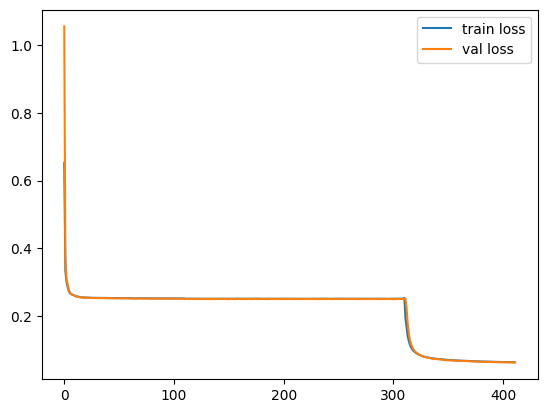

In [72]:
plt.plot(Trainer.losses, label="train loss")
plt.plot(Trainer.val_losses, label="val loss")
plt.legend()

In [73]:
# import pickle

# with open(trainer_file, 'wb') as outp:
#     pickle.dump(Trainer, outp, pickle.HIGHEST_PROTOCOL)


In [74]:
train_loader = DataLoader(dataset=trainset, shuffle=True, batch_size=2048)
test_loader = DataLoader(dataset=testset, shuffle=True, batch_size=2048)

In [75]:
batch_size = 10_000
data = DataLoader(trainset, shuffle=True, batch_size=batch_size)
imgs, _, labels = next(iter(data))

(mu, log_var), imgs_pred = VAE(imgs.to(device))

In [76]:
mu_mean = mu.mean(axis=0)
mu_std = mu.std(axis=0)


log_var_mean = log_var.mean(axis=0)
log_var_std = log_var.std(axis=0)

In [77]:
batch_noise = 10_000

In [78]:
mu_noised = torch.randn(size=(batch_noise, 64)).to(device)
log_var_noise = torch.randn(size=(batch_noise, 64)).to(device)

In [79]:
def rescale_noise(noise, mean, std):
    noise_scaled = (noise - noise.mean()) / noise.std()
    return noise_scaled * std + mean

In [80]:
std = torch.sqrt(torch.exp(log_var_noise))
eps = torch.randn_like(std)

z = mu_noised + eps * std

In [81]:
gen_imgs = VAE.decoder(z)
imgs_to_plot = gen_imgs[:16].cpu().detach().numpy().reshape(-1,28,28)

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

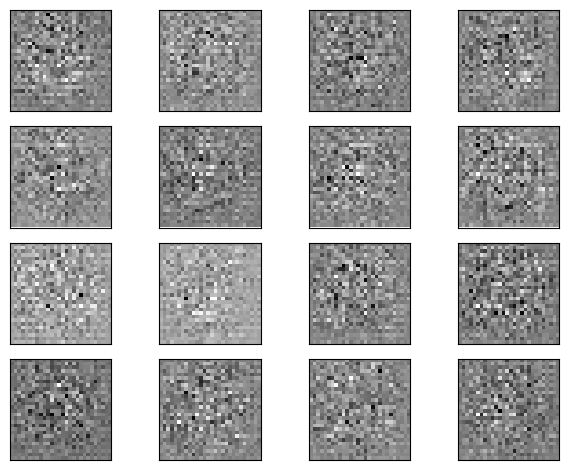

In [82]:
from util import tile_tv_images
tile_tv_images(images=imgs_to_plot)

In [83]:
VerifNet = VerificationNet(force_learn=False, file_name='models/verification_model_torch_ok_copy')

cov = VerifNet.check_class_coverage(data=gen_imgs, tolerance=.8)
pred, _ = VerifNet.check_predictability(data=gen_imgs, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 50.00%
Predictability: 91.65%


In [84]:
preds, beliefs = VerifNet.predict(data=gen_imgs)

In [85]:
k = 16

In [86]:
idx = np.flip(np.argsort(beliefs))[:k]

best_imgs = gen_imgs.cpu().detach().numpy().reshape(-1, 28, 28)[idx]
labels_best_imgs = preds[idx]

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>,
         <Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>],
        [<Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>,
         <Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>],
        [<Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>,
         <Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>],
        [<Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>,
         <Axes: title={'center': '0.0'}>, <Axes: title={'center': '0.0'}>]],
       dtype=object))

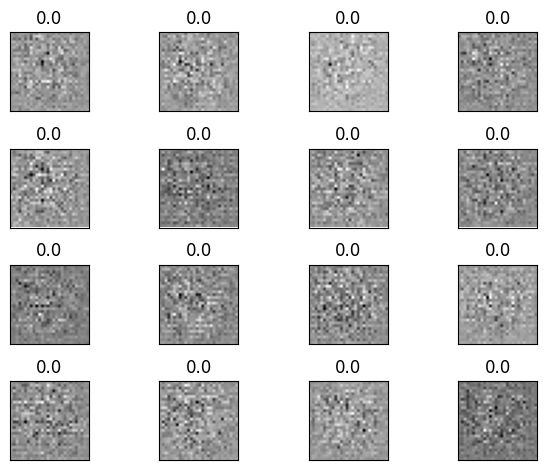

In [87]:
tile_tv_images(images=best_imgs, labels=labels_best_imgs)